<a href="https://colab.research.google.com/github/jyotidabass/Tongue-image-enhancement/blob/main/Tongue_image_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

def image_is_in_gray_scale(image):
    return len(image.shape) == 2

def make_image_negative(image):
    if not image_is_in_gray_scale(image):
        output = np.subtract([255, 255, 255], image)
        return output.astype(np.uint8)
    else:
        return np.subtract(255, image)

def histogram_of_grayscale(image):
    histogram = np.zeros(256)
    for row in image:
        for pixel in row:
            histogram[pixel] = histogram[pixel] + 1
    return histogram.astype(int)

def local_thresholding(image, kernel_size=7):
    output = padding(image, kernel_size)
    return apply_thresholding(image, output, kernel_size)


def padding(image, kernel_size):
    output = np.zeros(image.shape)
    up_side_inf_limit = 0
    up_side_sup_limit = int(kernel_size/2)
    for i in range(up_side_inf_limit, up_side_sup_limit):
        for j in range(image.shape[1]):
            output[i, j] = image[i, j]

    down_side_inf_limit = image.shape[0] - int(kernel_size/2)
    down_side_sup_limit = image.shape[0]
    for i in range(down_side_inf_limit, down_side_sup_limit):
        for j in range(image.shape[1]):
            output[i, j] = image[i, j]

    left_side_inf_limit = 0
    left_side_sup_limit = int(kernel_size/2)
    for i in range(image.shape[0]):
        for j in range(left_side_inf_limit, left_side_sup_limit):
            output[i, j] = image[i, j]

    right_side_inf_limit = image.shape[1] - int(kernel_size/2)
    right_side_sup_limit = image.shape[1]
    for i in range(image.shape[0]):
        for j in range(right_side_inf_limit, right_side_sup_limit):
            output[i, j] = image[i, j]
    return output

def apply_thresholding(image, output, kernel_size):
    off_set = int(kernel_size / 2)
    starting_row = off_set
    ending_row = image.shape[0] - off_set
    starting_column = off_set
    ending_column = image.shape[1] - off_set

    for i in range(starting_row, ending_row):
        for j in range(starting_column, ending_column):
            if not image_is_in_gray_scale(image):
                frame = image[i - off_set:i + off_set, j - off_set:j + off_set]
                median_hue = np.median(frame[:,:,0])
                median_sat = np.median(frame[:,:,1])
                median_val = np.median(frame[:,:,2])
                threshold_hue = int(median_hue) - 5
                threshold_sat = int(median_sat) - 5
                threshold_val = int(median_val) - 5

                if image[i, j, 0] > threshold_hue:
                    output[i, j] = 255
                if image[i, j, 1] > threshold_sat:
                    output[i, j] = 255
                if image[i, j, 2] > threshold_val:
                    output[i, j] = 255
            else:
                frame = image[i - off_set:i + off_set, j - off_set:j + off_set]
                median = np.median(frame)
                threshold = int(median) - 5
                if image[i,j] > threshold:
                    output[i,j] = 255

    if not image_is_in_gray_scale(image):
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if not np.array_equal(output[i, j], [255, 255, 255]):
                    output[i, j] = image[i, j]
    return output.astype(np.uint8)

def histogram_equalization(image):
    output = np.zeros(image.shape)
    N = image.shape[0] * image.shape[1]
    if not image_is_in_gray_scale(image):
        frequency_for_each_blue_level = np.zeros(256)
        frequency_for_each_green_level = np.zeros(256)
        frequency_for_each_red_level = np.zeros(256)
        max_blue_level = np.max(image[:,:,0])
        max_green_level = np.max(image[:,:,1])
        max_red_level = np.max(image[:,:,2])

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                blue_level = image[i, j, 0]
                green_level = image[i, j, 1]
                red_level = image[i, j, 2]
                frequency_for_each_blue_level[blue_level] = frequency_for_each_blue_level[blue_level] + 1
                frequency_for_each_green_level[green_level] = frequency_for_each_green_level[green_level] + 1
                frequency_for_each_red_level[red_level] = frequency_for_each_red_level[red_level] + 1
        normalized_histogram_for_blue_level = frequency_for_each_blue_level / N
        normalized_histogram_for_green_level = frequency_for_each_green_level / N
        normalized_histogram_for_red_level = frequency_for_each_red_level / N

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                blue_level = image[i, j, 0]
                green_level = image[i, j, 1]
                red_level = image[i, j, 2]
                new_blue_level = int(np.araound(normalized_histogram_for_blue_level[blue_level] * max_blue_level))
                new_green_level = int(np.around(normalized_histogram_for_green_level[green_level] * max_green_level))
                new_red_level = int(np.around(normalized_histogram_for_red_level[red_level] * max_red_level))
                output[i, j] = [new_blue_level, new_green_level, new_red_level]
    else:
        frequency_for_each_gray_level = np.zeros(256)
        max_gray_level = np.max(image)

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                gray_level = image[i, j]
                frequency_for_each_gray_level[gray_level] = frequency_for_each_gray_level[gray_level] + 1
        normalized_histogram_for_gray_level = frequency_for_each_gray_level/N
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                gray_level = image[i, j]
                output[i, j] = int(np.around(normalized_histogram_for_gray_level[gray_level] * max_gray_level))
    return output.astype(np.uint8)

In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

def read_image(path, color_scale = 'gray'):
    scale = 0
    if(color_scale == 'rgb'):
        scale = 1
    image = cv2.imread(path, scale)
    return image

def show_image(image, color_scale = 'gray'):
    image, color = adapt_image_to_color_scale(image, color_scale)
    plt.imshow(image, cmap=color, interpolation='bicubic', vmin=0, vmax=255)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def adapt_image_to_color_scale(image, color_scale):
    color = None
    if(color_scale != 'gray'):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        color = "gray"
    return image, color

def show_couple_of_images(image1, image2, title1 = None, title2 = None, color_scale = 'gray'):
    image1, color = adapt_image_to_color_scale(image1, color_scale)
    image2, color = adapt_image_to_color_scale(image2, color_scale)
    plt.subplot(121), plt.imshow(image1, cmap=color, interpolation='bicubic', vmin=0, vmax=255), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(image2, cmap=color, interpolation='bicubic', vmin=0, vmax=255), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

def show_histogram(histogram, x_label="", y_label=""):
    plt.plot(np.arange(histogram.size), histogram)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

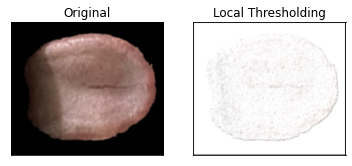

'output = histogram_equalization(image)\nshow_couple_of_images(image, output, "Original", "Equalized", color_scale)'

In [7]:
import numpy as np
import cv2

path= '/content/cropped-1E6AE7E2-F4F6-4EFC-AFEC-75B6AF988C47 - Abhishek Karekar.jpg'
#path= 'images/745x419.jpg'
#path = 'images/402x588.png'
#path= '/content/cropped-2EE4EF6B-A833-46A7-966F-9BBC30E14102 - Nidhee Paul.jpg'
#path= 'images/306x341.png'
#path= 'images/sonnet.png'
color_scale = "rgb"
image = read_image(path, color_scale)

# Threshold
output = local_thresholding(image, 7)
show_couple_of_images(image, output, "Original", "Local Thresholding", color_scale)

# Negative
"""
show_couple_of_images(image, make_image_negative(image), "Original", "Negative", "rgb")"""

# Histogram
"""
N = image.shape[0] * image.shape[1]
histogram = histogram_of_grayscale(image)
show_histogram(histogram/N, "Pixel intensity", "Pixel frequency")"""

# Histogram equalization
"""output = histogram_equalization(image)
show_couple_of_images(image, output, "Original", "Equalized", color_scale)"""